In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
import webbrowser


In [142]:
# Seed for reproducibility
np.random.seed(42)

# Governorate data
regions = [
    ("Tunis", 36.8065, 10.1815, 10),
    ("Ariana", 36.8663, 10.1647, 9),
    ("Ben Arous", 36.7435, 10.2310, 45),
    ("Manouba", 36.8083, 10.0970, 8),
    ("Bizerte", 37.2746, 9.8739, 35),
    ("Nabeul", 36.4513, 10.7364, 30),
    ("Beja", 36.7333, 9.1833, 18),
    ("Jendouba", 36.5011, 8.7802, 20),
    ("Kef", 36.1826, 8.7140, 15),
    ("Siliana", 36.0833, 9.3667, 14),
    ("Sousse", 35.8256, 10.6369, 38),
    ("Monastir", 35.7770, 10.8262, 34),
    ("Mahdia", 35.5047, 11.0622, 40),
    ("Kairouan", 35.6712, 10.1005, 12),
    ("Sidi Bouzid", 35.0382, 9.4840, 16),
    ("Kasserine", 35.1676, 8.8365, 17),
    ("Sfax", 34.7406, 10.7603, 32),
    ("Gabes", 33.8815, 10.0982, 28),
    ("Mednine", 33.3549, 10.5055, 27),
    ("Tataouine", 32.9297, 10.4518, 25),
    ("Gafsa", 34.4250, 8.7842, 26),
    ("Tozeur", 33.9197, 8.1335, 22),
    ("Kebili", 33.7074, 8.9690, 24),
    ("Zaghouan", 36.4000, 10.1400, 18)
]

regions_df = pd.DataFrame(regions, columns=["region", "lat", "lon", "outage_frequency"])

def generate_incidents(regions_df, noise_std=0.05):
    """Generate incident data points around each governorate centroid."""
    data = []
    for _, row in regions_df.iterrows():
        lat_noise = np.random.normal(row['lat'], noise_std, int(row['outage_frequency']))
        lon_noise = np.random.normal(row['lon'], noise_std, int(row['outage_frequency']))
        region_data = pd.DataFrame({
            "region": row["region"],
            "lat": lat_noise,
            "lon": lon_noise
        })
        data.append(region_data)
    return pd.concat(data, ignore_index=True)

df = generate_incidents(regions_df)


In [143]:
# Summarize the generated data
summary = df.groupby('region').agg(
    incidents_count=('lat', 'count'),
    mean_lat=('lat', 'mean'),
    mean_lon=('lon', 'mean')
).reset_index()

# Display table sorted by incidents count
summary = summary.sort_values(by='incidents_count', ascending=False)
summary


,region,incidents_count,mean_lat,mean_lon
2,Ben Arous,45,36.742747,10.230883
11,Mahdia,40,35.506506,11.074455
19,Sousse,38,35.829400,10.632642
3,Bizerte,35,37.281667,9.885328
14,Monastir,34,35.770125,10.810908
16,Sfax,32,34.729760,10.775031
15,Nabeul,30,36.448955,10.730421
4,Gabes,28,33.882036,10.105617
13,Mednine,27,33.361837,10.531726
5,Gafsa,26,34.433584,8.772214


The dataset simulates water outage incidents across Tunisian governorates using latitude and longitude coordinates.
Each governorate contributes multiple data points based on its outage frequency .
The aim of Mean Shift clustering here is to automatically detect spatial hotspots (areas where outages tend to concentrate geographically).

Estimated bandwidth: 0.7838

Total clusters found: 5

cluster
0    12
1     4
2     3
3     4
4     3
Name: region, dtype: int64


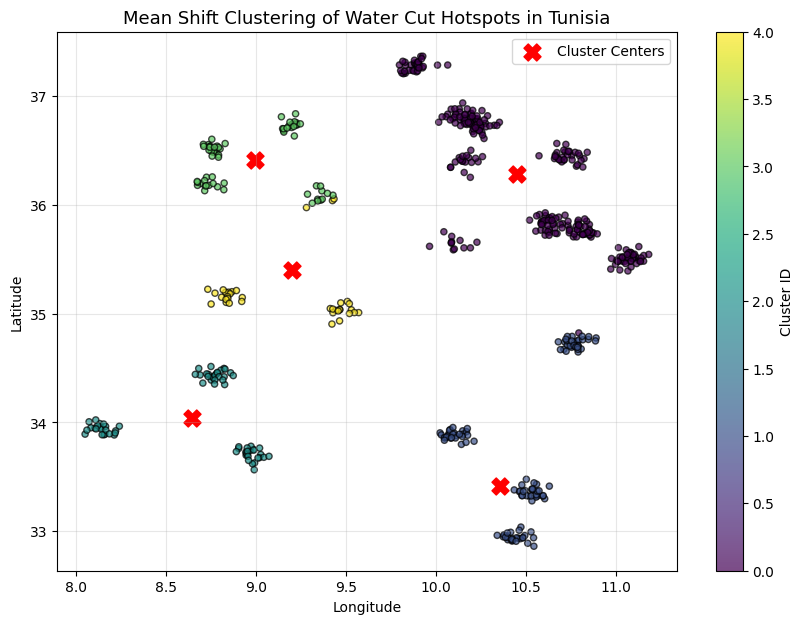

In [ ]:
# Step 1: Data Initialization
coords = df[['lat', 'lon']].to_numpy()

scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Step 2: Bandwidth Selection

bandwidth = estimate_bandwidth(coords_scaled, quantile=0.15, n_samples=500)
print(f"Estimated bandwidth: {bandwidth:.4f}")

# Step 3: Fitting the Mean Shift Algorithm
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(coords_scaled)

"""
Mean Shift working principle:
- Each point finds all neighboring points within the bandwidth.
- Computes the mean (center of mass) of those neighbors.
- Shifts toward that mean.
- Repeats until convergence (shift becomes very small).
"""

# Step 4: Extract Cluster Centers
centers_scaled = ms.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)

# Step 5: Assign Cluster Labels

df['cluster'] = ms.labels_
 
# Step 6: Display Summary
total_clusters = len(np.unique(ms.labels_))
print(f"\nTotal clusters found: {total_clusters}\n")
print(df.groupby('cluster')['region'].nunique())


# Step 7: Visualization
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    df['lon'], df['lat'], c=df['cluster'],
    cmap='viridis', s=20, alpha=0.7, edgecolor='k'
)
plt.scatter(
    centers[:, 1], centers[:, 0],
    c='red', marker='X', s=150, label='Cluster Centers'
)



plt.title("Mean Shift Clustering of Water Cut Hotspots in Tunisia", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

cbar = plt.colorbar(scatter)
cbar.set_label('Cluster ID')

plt.grid(alpha=0.3)
plt.show()



The bandwidth determines the “search radius” of each point when looking for nearby points with high density.

bandwidth of 0.7838 means the algorithm considered points within that scaled radius when shifting toward denser regions.
It balances local precision with a broader regional overview.

The Mean Shift algorithm automatically discovered 5 distinct hotspots of water cut incidents across Tunisia.
This means that, based on the spatial distribution of outage data, there are five main high-density areas where water cuts are most likely to occur.

In [ ]:
# Simulate outage_frequency if missing )
if 'outage_frequency' not in df.columns:
    np.random.seed(42)
    df['outage_frequency'] = np.random.randint(1, 11, size=len(df))

tunisia_center = [35.8, 10.1]  # [lat, lon]
m = folium.Map(location=tunisia_center, zoom_start=7)

# Add outage points
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=4,
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"Outage frequency: {row['outage_frequency']}"
    ).add_to(m)


# Add cluster centers

for c in centers:
    folium.Marker(
        location=[c[0], c[1]],  # [lat, lon]
        icon=folium.Icon(color='red', icon='tint'),
        popup=f"Cluster center: ({c[0]:.2f}, {c[1]:.2f})"
    ).add_to(m)


file_name = "tunisia_water_cut_clusters.html"
m.save(file_name)
print(f"Map saved as '{file_name}'")

webbrowser.open(file_name)


Map saved as 'tunisia_water_cut_clusters.html'


True

What This Visualization Demonstrates:
Bandwidth as a Scale Parameter
     Large bandwidth = Fewer, larger clusters (over-smoothing)
     Small bandwidth = More, smaller clusters (over-segmentation)

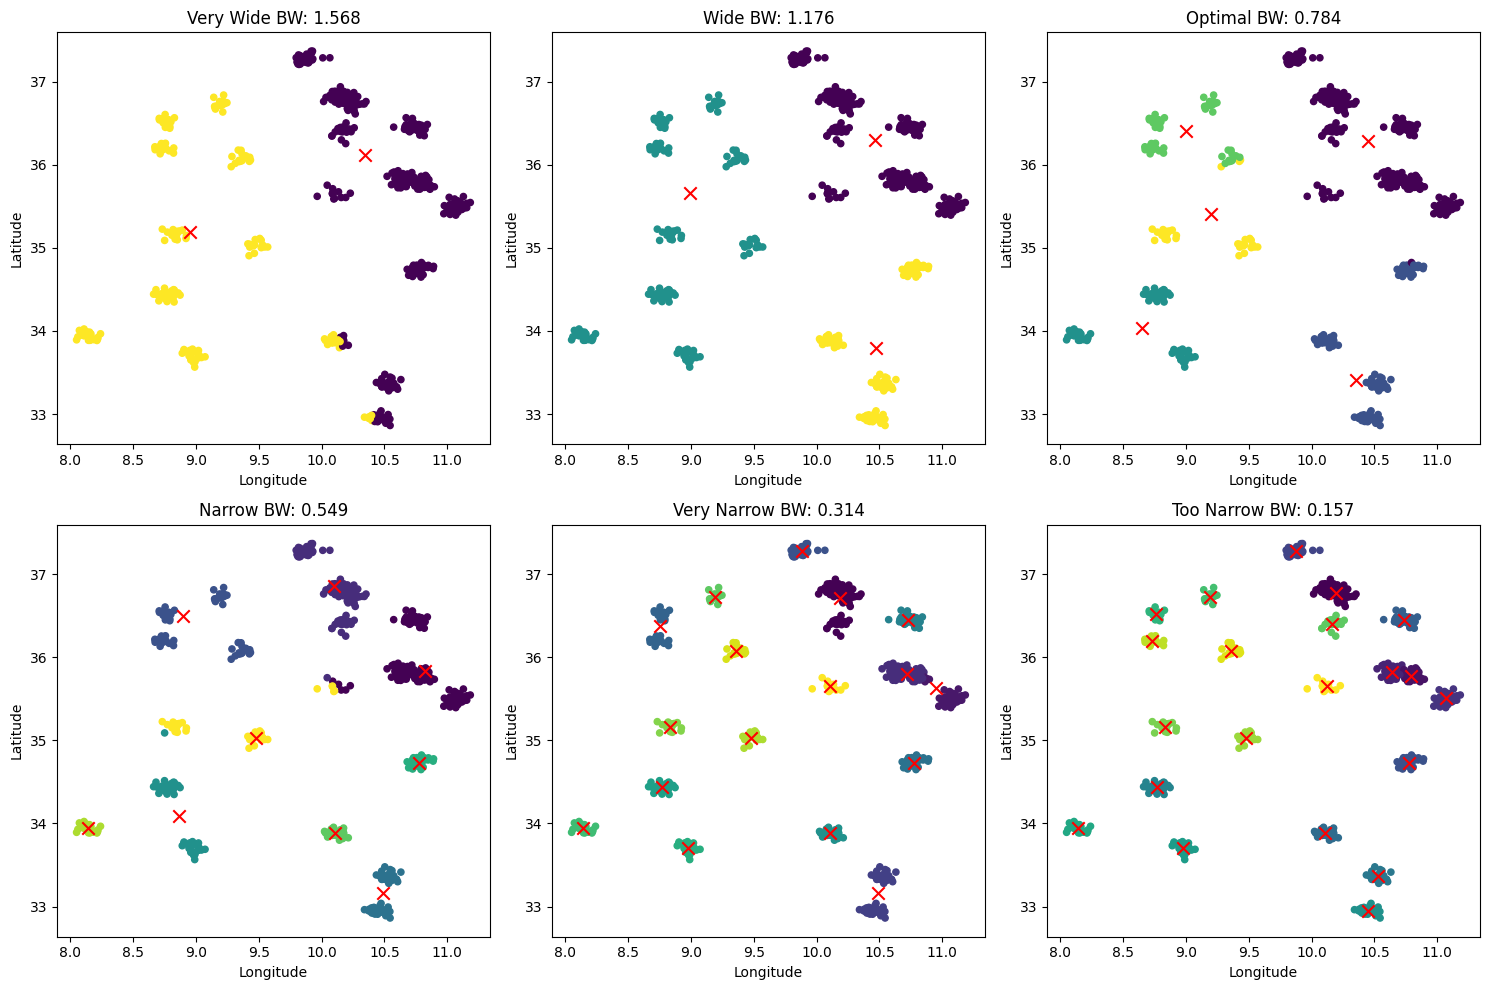

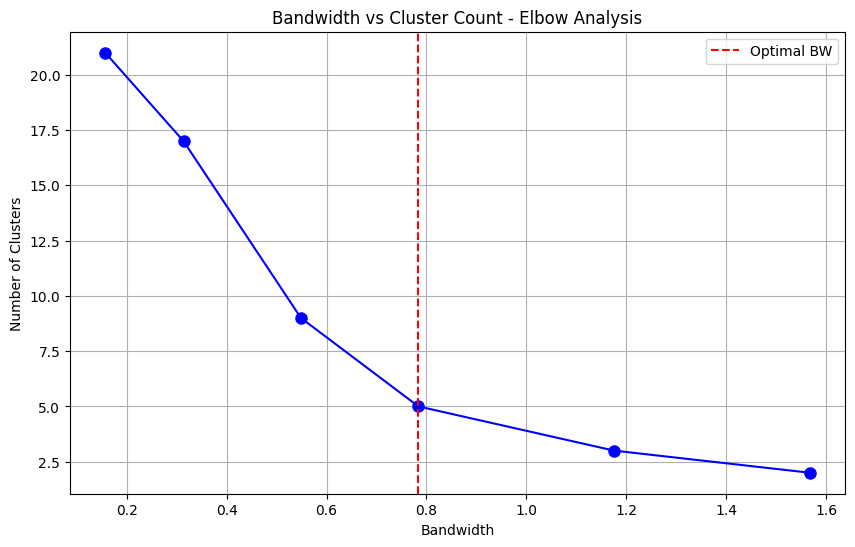

Cluster counts by bandwidth:
Very Wide    (BW: 1.568):  2 clusters
Wide         (BW: 1.176):  3 clusters
Optimal      (BW: 0.784):  5 clusters
Narrow       (BW: 0.549):  9 clusters
Very Narrow  (BW: 0.314): 17 clusters
Too Narrow   (BW: 0.157): 21 clusters


In [146]:
# Alternative: Show progression using multiple bandwidths
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

bandwidths = [bandwidth * 2, bandwidth * 1.5, bandwidth, bandwidth * 0.7, bandwidth * 0.4, bandwidth * 0.2]
titles = ['Very Wide', 'Wide', 'Optimal', 'Narrow', 'Very Narrow', 'Too Narrow']

for idx, (bw, title) in enumerate(zip(bandwidths, titles)):
    ms_temp = MeanShift(bandwidth=bw, bin_seeding=True)
    ms_temp.fit(coords_scaled)
    centers_temp = scaler.inverse_transform(ms_temp.cluster_centers_)
    
    axes[idx].scatter(df['lon'], df['lat'], c=ms_temp.labels_, cmap='viridis', s=20)
    axes[idx].scatter(centers_temp[:, 1], centers_temp[:, 0], c='red', marker='x', s=80)
    axes[idx].set_title(f'{title} BW: {bw:.3f}')
    axes[idx].set_xlabel('Longitude')
    axes[idx].set_ylabel('Latitude')

plt.tight_layout()
plt.show()
# Quantitative analysis of bandwidth effect
cluster_counts = []
for bw in bandwidths:
    ms_temp = MeanShift(bandwidth=bw, bin_seeding=True)
    ms_temp.fit(coords_scaled)
    cluster_counts.append(len(np.unique(ms_temp.labels_)))

plt.figure(figsize=(10, 6))
plt.plot(bandwidths, cluster_counts, 'bo-', markersize=8)
plt.xlabel('Bandwidth')
plt.ylabel('Number of Clusters')
plt.title('Bandwidth vs Cluster Count - Elbow Analysis')
plt.grid(True)
plt.axvline(x=bandwidth, color='red', linestyle='--', label='Optimal BW')
plt.legend()
plt.show()

print("Cluster counts by bandwidth:")
for bw, count, title in zip(bandwidths, cluster_counts, titles):
    print(f"{title:12} (BW: {bw:.3f}): {count:2d} clusters")